In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

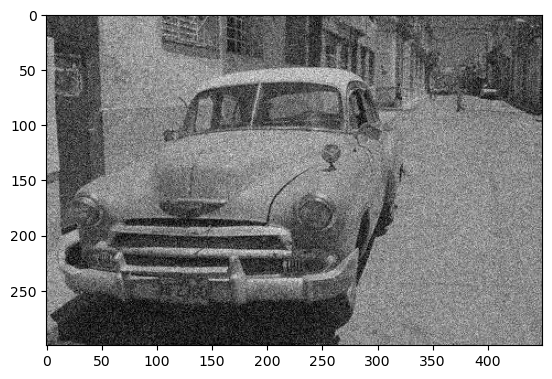

In [3]:
image = cv2.imread(r"C:\Users\DS17\Desktop\IVP 011\Image Restoration\car_noise.png", cv2.IMREAD_GRAYSCALE)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)

In [4]:
image.shape

(300, 450, 3)

In [5]:
gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray_img.shape

(300, 450)

**Adding Noise to the image**

In [6]:
# Adding Noise to the image
def Gaussain_noise(image, mean=0, sigma=15):
    gauss_noise = np.random.normal(mean, sigma, image.shape)
    gauss_noisy_image = np.clip(image+gauss_noise, 0, 255).astype(np.uint8)
    return gauss_noisy_image

In [7]:
def Rayleigh_noise(image, sigma=1.5):
    rayleigh_noise = np.random.rayleigh(sigma, image.shape)
    ray_noisy_image = np.clip(image+rayleigh_noise, 0, 255).astype(np.uint8)
    return ray_noisy_image

In [12]:
def salt_and_pepper_noise(image, salt_prob=0.2, pepper_prob=0.3):
    noisy_image = image.copy()
    noisy_pixel = image.size
    
    num_salt = int(noisy_pixel*salt_prob)
    salt_coords = [np.random.randint(0,i-1,num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255
    
    num_pepper = int(noisy_pixel*pepper_prob)
    pepper_coords = [np.random.randint(0,i-1,num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0
    
    return noisy_image

**Applying filters to remove the noise**

In [9]:
def fourier_transform(image):
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)
    marginal_spectrum = np.log(1+ np.abs(dft_shift))
    return dft, dft_shift, marginal_spectrum

In [26]:
def low_pass_filter(image, radius=50):
    dft, dft_shift, _ = fourier_transform(image)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    # Create a circular mask
    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 1, -1)

    # Apply mask and inverse DFT
    filtered_dft = dft_shift * mask
    filtered_image = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_dft)))
    return np.uint8(filtered_image)

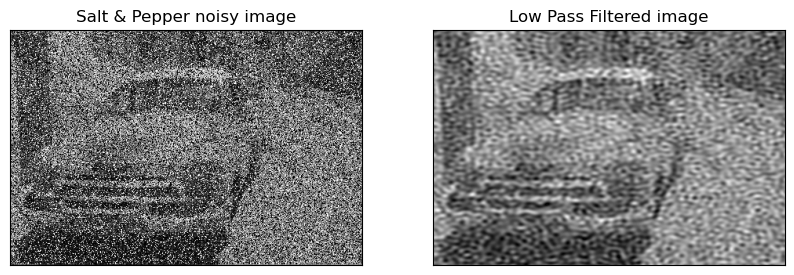

In [28]:
# Applying on our image
noisy_gray_img = salt_and_pepper_noise(gray_img)

# Applying filter to our noisy image
restored_image = low_pass_filter(noisy_gray_img)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(noisy_gray_img, cmap='gray')
plt.title("Salt & Pepper noisy image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(restored_image, cmap='gray')
plt.title("Low Pass Filtered image"), plt.xticks([]), plt.yticks([])
plt.show()

In [32]:
s_p_noise = salt_and_pepper_noise(gray_img)

H = np.abs(np.fft.fftshift(np.fft.fft2(s_p_noise)))**2

In [35]:
def Wiener_filter(image, H, kernel=5):
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)
    H_ = np.abs(dft_shift)**2
    
    wiener_filter = H_/(H_ + H) # H_ is the conjugate of H
    
    restored_dft_shifted = dft_shift * wiener_filter
    
    restored_dft = np.fft.ifftshift(restored_dft_shifted)
    restored_image = np.fft.ifft2(restored_dft)
    
    restored_image = np.real(restored_image)
    restored_image = np.clip(restored_image,0,255).astype(np.uint8)
    
    return restored_image
    

In [36]:
# Test case 1: Applying wiener filter on salt and pepper noisy image
restored_wiener_image = Wiener_filter(noisy_gray_img, H)

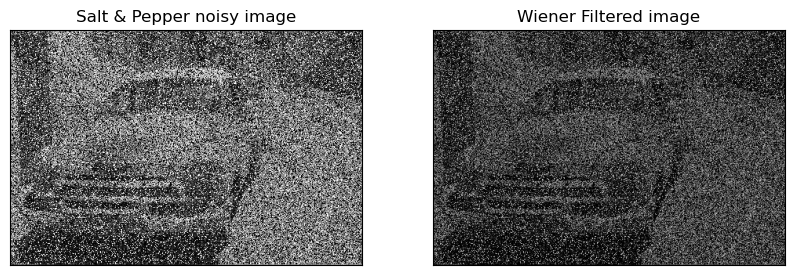

In [38]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(noisy_gray_img, cmap='gray')
plt.title("Salt & Pepper noisy image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(restored_wiener_image, cmap='gray')
plt.title("Wiener Filtered image"), plt.xticks([]), plt.yticks([])
plt.show()

In [39]:
# Test case 2: Applying wiener filter on gaussian noisy image
gauss_noise = Gaussain_noise(gray_img)

Hg = np.abs(np.fft.fftshift(np.fft.fft2(gauss_noise)))**2

In [42]:
gauss_noise_img = np.clip(gray_img+gauss_noise, 0, 255).astype(np.uint8)

In [44]:
restored_gauss_image = Wiener_filter(gauss_noise_img, Hg)

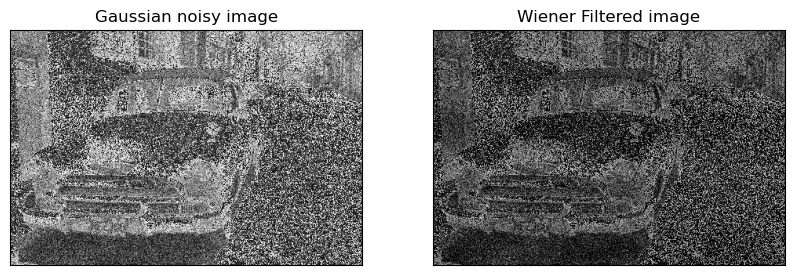

In [45]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(gauss_noise_img, cmap='gray')
plt.title("Gaussian noisy image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(restored_gauss_image, cmap='gray')
plt.title("Wiener Filtered image"), plt.xticks([]), plt.yticks([])
plt.show()